#### Our approach did outperform Gautamshahi's  approach and could even partly outperform Sourya's approach 

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
  
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13264032793730258205
]


In [6]:
import platform
import tensorflow as tf

if tf.test.is_built_with_cuda() == False:
    print('YOU WORK WITHOUT GPU')

print(platform.machine(), '\n')
print(platform.version(), '\n')
print(platform.platform(), '\n')
print(platform.uname(), '\n')
print(platform.system(), '\n')
print(platform.processor())

AMD64 

10.0.19041 

Windows-10-10.0.19041-SP0 

uname_result(system='Windows', node='DESKTOP-FAKSDIV', release='10', version='10.0.19041', machine='AMD64', processor='AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD') 

Windows 

AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD


In [1]:
import tensorflow as tf

import re
import pandas as pd
import numpy as np
import json
import re
import string

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

In [2]:
df_drive = pd.read_csv('fullset.csv')

### Define Tokens and Transform sequences

In [3]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
label_id = lb_make.fit_transform(df_drive.label)

df_drive['label_id'] = label_id
df_drive.dropna(inplace=True)

In [4]:
# The maximum number of most frequent words to be used.
MAX_NB_WORDS = 29000
# Max number of words in each row
MAX_SEQUENCE_LENGTH = 150
#feature vector length
HIDDEN_DIM = 150

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df_drive['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 29601 unique tokens.


In [5]:
import pickle as pkl
with open('tokenizer.pkl','wb') as f:
    pkl.dump(tokenizer, f)

In [6]:
# define X and Y
X = tokenizer.texts_to_sequences(df_drive['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(df_drive['label']).values
print('Shape of label tensor:', Y.shape)

onehot_labels = pd.get_dummies(df_drive['label'])
labels = onehot_labels.drop_duplicates(subset=onehot_labels.columns).reset_index(drop=True)

Shape of data tensor: (14333, 150)
Shape of label tensor: (14333, 2)


In [7]:
with open('FakeDetection.pkl','wb') as f:
    pkl.dump(X, f)

#### Define Test-Train Data

In [8]:
from sklearn.model_selection  import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

## Define Model

In [9]:
#save model
from __future__ import absolute_import, division, print_function
import os

checkpoint_path = "model_pretrain/model"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding,SpatialDropout1D, LSTM,Conv1D,MaxPooling1D
from tensorflow.keras import layers

def CovFake_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, HIDDEN_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation='softmax'))
    
    return model 

## Train Model

In [11]:
model_path = "model_pretrain/model"

model = CovFake_model()
model.load_weights(model_path)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [17]:
model = CovFake_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

epochs = 100
batch_size = 64
model.fit(X_train, Y_train,epochs=epochs, batch_size=batch_size,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
144/144 [==============================] - 59s 396ms/step - loss: 0.2895 - acc: 0.8694 - val_loss: 0.1552 - val_acc: 0.9433
Epoch 2/100
144/144 [==============================] - 57s 393ms/step - loss: 0.0699 - acc: 0.9757 - val_loss: 0.1363 - val_acc: 0.9486
Epoch 3/100
144/144 [==============================] - 57s 396ms/step - loss: 0.0204 - acc: 0.9932 - val_loss: 0.1217 - val_acc: 0.9555
Epoch 4/100
144/144 [==============================] - 58s 406ms/step - loss: 0.0073 - acc: 0.9987 - val_loss: 0.1695 - val_acc: 0.9516
Epoch 5/100
144/144 [==============================] - 59s 408ms/step - loss: 0.0033 - acc: 0.9992 - val_loss: 0.1828 - val_acc: 0.9486


## Evaluation

In [19]:
_, accr = model.evaluate(X_test,Y_test)

print('\n Test set\n Accuracy: {:0.3f}'.format(accr))

90/90 [==============================] - 3s 36ms/step - loss: 0.1837 - acc: 0.9533

 Test set
 Accuracy: 0.953


In [20]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)

y_pred_label = []
for i in y_pred:
    if i[0] > i[1]:
        y_pred_label.append(0)
    else:
        y_pred_label.append(1)

y_true_label = []
for i in Y_test:
    if i[0] > i[1]:
        y_true_label.append(0)
    else:
        y_true_label.append(1)
        
print(classification_report(y_true_label, y_pred_label))

45/45 [==============================] - 3s 53ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1684
           1       0.95      0.94      0.94      1183

    accuracy                           0.95      2867
   macro avg       0.95      0.95      0.95      2867
weighted avg       0.95      0.95      0.95      2867



In [21]:
labels_dic = {
    1:'real',
    0: 'fake',
}

Y_index_labels = [list(i).index(1) for i in Y_test]
Y_test_str = [labels_dic[i] for i in Y_index_labels]

y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)
Y_preds_str = [labels_dic[i] for i in list(y_classes)]

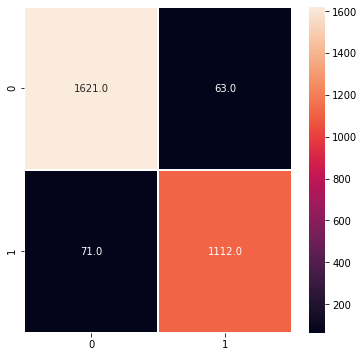

In [22]:
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = confusion_matrix(y_pred=Y_preds_str,y_true=Y_test_str)

fig,ax = plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix,annot=True,fmt="0.1f",linewidths=1.5)
plt.show()

### Evaluation of wrong prediction

In [23]:
test_text = tokenizer.sequences_to_texts(X_test)

df_test = pd.DataFrame({'test_text':test_text, 
                        'true_label':y_true_label,
                        'pred_label': y_pred_label})

#### Fake (0) labeled as Real (1) - FalsePositives

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import stop_words as sw
from itertools import chain
import matplotlib.pyplot as plt

def cleantext(list_text):
    list_text = [item.replace('[»„‘’“”…]', ' ') for item in list_text]
    list_text = [item.replace('\w*\d\w*', 'Number') for item in list_text]
    list_text = [item.replace(r"https?://\S+|www\.\S+", ' ') for item in list_text]
    list_text = [item.replace(r'[\u0080-\uffff]w{1-3}', " ") for item in list_text]
    list_text = [item.replace(r"[^\x00-\x7F\w{1,3}]+", ' ') for item in list_text]
    list_text = [item.replace(r"[^\x00-\x7F\w{1,3}]+", ' ') for item in list_text]
    
    
    list_text = [i.split() for i in list_text]
    list_text = list(chain.from_iterable(list_text))
    
    clean_elements = ['the', 'to', 't', 'in', 'for', 'and', 'co']
    list_text = [item for item in list_text if item not in clean_elements]

    return list_text


stop_words = sw.get_stop_words('english')

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [26]:
fp_test = [rows for index,rows in df_test.iterrows() if rows.true_label == 0 and rows.pred_label == 1]
fp_test = pd.DataFrame(fp_test)

fp_texts = [i for i in list(fp_test.test_text)]
fp_texts

['for our coronawarriors coronavirusindia indiafightscorona narendramodi we are united and we will fight against such chinesevirus chinaindiafaceoff boycottmadeinchina boycottchineseproduct are u with me https t co b6m4wt1ece',
 'number of covid related deaths has fallen since federal police started an investigation on the number of deaths',
 'the photo shows a letter purportedly from the california department of social services that mandates coronavirus testing for participants of state assistance programs and warns that children may be removed from the household if someone tests positive',
 'special report we could lift the lockdown today if everyone agrees to drive bumper cars all the time https t co vul1m40jlh https t co uu1k74ihik',
 "the most up to date data in victoria for 2020 was consistent with that for 2019 despite concerns due to covid19 however the numbers remain troubling according to vic's state coroner and don't mitigate the fact that there's been an increase in calls t

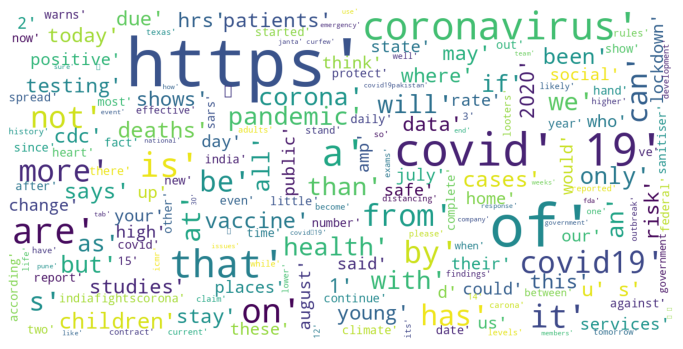

In [27]:
words_fp = cleantext(fp_texts)
show_wordcloud(words_fp)

#### Real (1) labeled as Fake (0) - FalseNegatives

In [28]:
fn_test = [rows for index,rows in df_test.iterrows() if rows.true_label == 1 and rows.pred_label == 0]
fn_test = pd.DataFrame(fn_test)

fn_texts = [i for i in list(fn_test.test_text)]
fn_texts

['twofold increase in mortality among coronavirus patients with hypertension https t co enlbntdzbl',
 'at this rate india is slated to overtake usa in testing',
 'another reason is the casual attitude of people towards covid 19 as people are seen in crowded places without any taking any precautionary measures such as wearing a facemask maintaining socialdistancing etc resulting in people getting infected with the novel coronavirus',
 "scientists ask without trial data how can we trust russia's covid vaccine https t co garcuf0pji https t co 0bdca7lf56",
 'thus enhanced and timely testing is not only keeping the positivity rate low but also the fatality rate low',
 'clothing is unlikely to be a huge source of coronavirus transmission https t co 8tqzufi68l',
 "did trump golf hold rallies after learning about covid 19 threat after sen mitch mcconnell suggested the government's response to the initial coronavirus outbreak was in part distracted by the president's impeachment rebuttal memes 

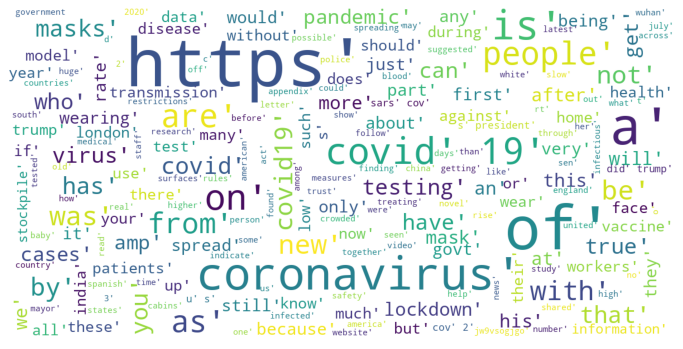

In [29]:
words_fn = cleantext(fn_texts)
show_wordcloud(words_fn)